# MAP 568 Project

Maxime Vincent & Swann Chelly

In [1]:
import numpy as np

from constant import *
import pandas as pd
from scipy import *
from scipy import stats
from pylab import *   
import scipy
from scipy.integrate import odeint # Module de résolution des équations différentielles
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [2]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps,variables, constants):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    
    if type(variables)!= dict:
        variables = dict(zip(variables_keys,variables))
        constants = dict(zip(constants_keys, constants))
    
    
    
    tau = constants['tau_0']*np.exp(-variables['mu']*max(temps-variables['N'],0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_moins
    DI_plus = variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_plus
    DR_moins = constants['gamma_IR']*I_moins
    DR_plus_I = constants['gamma_IR']*I_plus
    DH = constants['gamma_IH']*(I_moins + I_plus)-(constants['gamma_HR']+constants['gamma_HD']+constants['gamma_HU'])*H
    DU = constants['gamma_IU']*(I_moins + I_plus)+constants['gamma_HU']*H-(constants['gamma_UR'] + constants['gamma_UD'])*U
    DR_plus_H = constants['gamma_HR']*H+constants['gamma_UR']*U
    DD =constants['gamma_UD']*U+constants['gamma_HD']*H  
    DD_R = (variables['lambda_1']+constants['gamma_IH']+constants['gamma_IU'])*I_moins-D_R
    
    
    return([DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R])


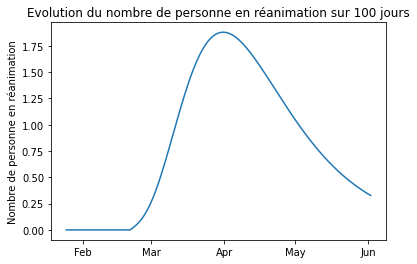

In [3]:
# Analyse des résultats

variables = init_variables()
constants = compute_constants(variables)


syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,constants['tbis'], args = (variables,constants))
start = np.zeros((variables['t_0'], simulation.shape[1]))
start[:,0]  = global_constants['S_0']
simulation = np.concatenate((start,simulation))
plt.plot(pd.date_range(start =  '2020-01-25', end = '2020-06-02', freq = 'D'),simulation[:,6])
plt.title(f"Evolution du nombre de personne en réanimation sur {global_constants['T_MAX']} jours")
plt.ylabel("Nombre de personne en réanimation")

### Permet d'avoir un axe des abscisses lisible
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()





2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [4]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 
M = 10000

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur {M} simulations")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        variables = init_variables(deltaT=global_constants['deltaT'],global_constants = global_constants)
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['tbis'], args = (variables,constants))  
        start = np.zeros((variables['t_0'], simulation.shape[1]))
        start[:,0]  = global_constants['S_0']
        simulation = np.concatenate((start,simulation))
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*global_constants['deltaT']))
        pos.append(np.max(simulation[:,1]))

        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)

Echantillonnage de Monte Carlo sur 10000 simulations


100% |########################################################################|


La valeur moyenne du pic est de 27727.57 et appartient à l'intervalle de confiance à 95% suivant : [26435.23,29019.91] 
 Le quantile à 10% du pic de réanimation est : 30.346036564341137
 Le quantile à 90% du pic de réanimation est : 89732.70484410795


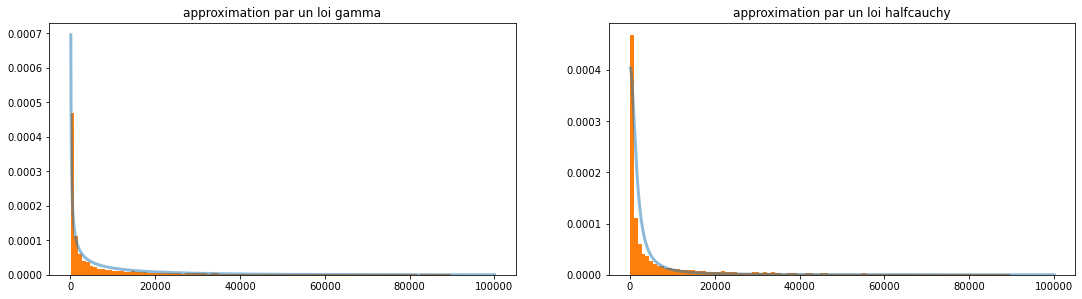

En bouclant sur l'ensemble des distributions (dans un code annexe) de scipy nous avons trouvés que les 2 lois suivantes fittent le mieux la nombre de cas maximale en réanimation :
-Loi gamma de parametre 0.36 recentré en 30 et mis à l'échelle avec un facteur scale de 25094
-Loi halfcauchy recentré en 30 et mis à l'échelle avec un facteur scale de 1573

Pour cette approximation nous avons pris les resultat de la simulation compris entre le quantile 10 et 90% pour retirer certaines valeurs qui pouvaient être trop extremes


In [86]:
import warnings
warnings.filterwarnings("ignore")
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

"""
fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100, density = 1)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if (value > q_10 and value < q_90)], bins = 100, density = True)
axs[1].set_title('Entre Quantile à 10 et 90 %')
x=np.arange(0,max([value for value in peak_value if (value > q_10 and value < q_90)]), 0.01)
Moy = np.mean([value for value in peak_value if (value > q_10 and value < q_90)])
Median = np.median([value for value in peak_value if (value > q_10 and value < q_90)])
axs[1].plot(x,stats.expon.pdf(x, scale=Median), label="densité") 
plt.subplots_adjust(hspace=0.5)
"""
list_ = ['gamma', 'halfcauchy']
donnees = [value for value in peak_value if (value > q_10 and value < q_90)]

x = np.arange(100,100000,0.1)

lois_param = []
for i, dist_name in enumerate(list_) : 
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(donnees)
    lois_param +=[param]
    loc = param[-2]
    scale = param[-1]
    arg = param[:-2]
    
    pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
    plt.subplot(1, 2, i+1)
    plt.plot(x, pdf, label=dist_name, linewidth=3, alpha = 0.5)  
    plt.hist(donnees, bins = 100, density = True)
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=1, wspace=None, hspace=None)
    plt.title("approximation par un loi "+ dist_name)
plt.show()
print("En bouclant sur l'ensemble des distributions (dans un code annexe) de scipy nous avons trouvés que les 2 lois suivantes fittent le mieux la nombre de cas maximale en réanimation :")
print("-Loi gamma de parametre "+ str(round(lois_param[0][0],2)) +" recentré en "+str(round(lois_param[0][1]))+" et mis à l'échelle avec un facteur scale de "+ str(round(lois_param[0][2]))  )
print("-Loi halfcauchy recentré en "+str(round(lois_param[1][0]))+" et mis à l'échelle avec un facteur scale de "+ str(round(lois_param[1][1])) )
print()
print('Pour cette approximation nous avons pris les resultat de la simulation compris entre le quantile 10 et 90% pour retirer certaines valeurs qui pouvaient être trop extremes')

La valeur moyenne du pic est de 85.71 et appartient à l'intervalle de confiance à 95% suivant : [85.38,86.04] 
 Le quantile à 10% du pic de réanimation est : 67.0
 Le quantile à 90% du pic de réanimation est : 112.0


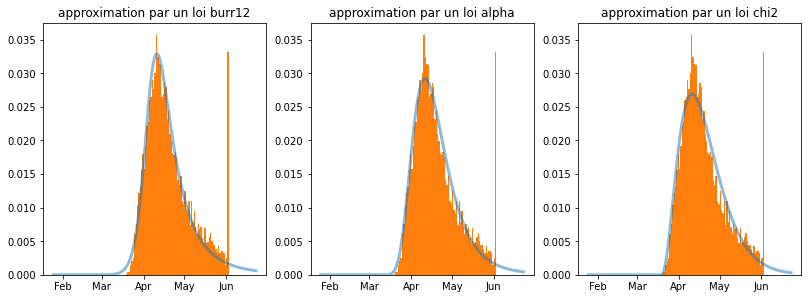

En bouclant sur l'ensemble des distributions (dans un code annexe) de scipy nous avons trouvés que les 4 lois suivantes fittent la date du maximum de l'épidémie :
-Loi de Burr (type XII) de parametre 15.0 et 0.39 recentré en -0.18 et mis à l'échelle avec un facteur scale de 73
-Loi alpha de parametre 4.88 recentré en 10 et mis à l'échelle avec un facteur scale de  352
-Loi du chi2 de parametre 7 recentré en 54 et mis à l'échelle avec un facteur scale de 4


In [87]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

"""
fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 30)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if (day > q_10_day and day < q_90_day)], bins = 30)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)
"""

list_ = ['burr12', 'alpha', 'chi2']
donnees = np.copy(peak_day)
lois_param =[]
x_dates = pd.date_range(start =  '2020-01-25', end = '2020-06-23', freq = 'D')
x= np.arange(0,len(x_dates),1)
for i, dist_name in enumerate(list_) : 
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(donnees)
    lois_param +=[param]
    loc = param[-2]
    scale = param[-1]
    arg = param[:-2]
    pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
    plt.subplot(1, 4, i+1)
    plt.plot(x_dates, pdf, label=dist_name, linewidth=3, alpha = 0.5) 
    d = []
    for i in range(len(donnees)):
        d += [x_dates[donnees[i]]]
    plt.hist(d, bins = timing, density = True)
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=1, wspace=None, hspace=None)
    
    plt.title("approximation par un loi "+ dist_name)
    ### Permet d'avoir un axe des abscisses lisible
    locator = mdates.MonthLocator()
    fmt = mdates.DateFormatter('%b')
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
plt.show()


plt.show()
print("En bouclant sur l'ensemble des distributions (dans un code annexe) de scipy nous avons trouvés que les 4 lois suivantes fittent la date du maximum de l'épidémie :")
print("-Loi de Burr (type XII) de parametre "+ str(round(lois_param[0][0],2)) +" et "+ str(round(lois_param[0][1],2))+ " recentré en "+str(round(lois_param[0][2],2))+" et mis à l'échelle avec un facteur scale de "+ str(round(lois_param[0][3]))  )
print("-Loi alpha de parametre "+ str(round(lois_param[1][0],2)) +" recentré en "+str(round(lois_param[1][1]))+" et mis à l'échelle avec un facteur scale de  "+ str(round(lois_param[1][2]))  )
print("-Loi du chi2 de parametre "+ str(round(lois_param[2][0])) +" recentré en "+str(round(lois_param[2][1]))+" et mis à l'échelle avec un facteur scale de "+ str(round(lois_param[2][2]))  )

# Analyse de sensibilité qualitative : Criblage

## Criblage avec SALib

In [88]:
from SALib.analyze import morris
from SALib.sample import morris as sample_morris

In [89]:
problem = {
    'num_vars': 15,
    'names': ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD','R_0','mu','lambda_1','t_0','N','N_I','N_H','N_U','I_moins_0'],
    'bounds': [[0.4,0.9],[0.05,0.2],[0.01,0.04],[0.1,0.2],[0.1,0.2],[0.2,0.4],[2.9,3.4],[0.01,0.08],[10**(-4),10**(-3)],[0,30],[30,50],
[8,12],[15,25],[10,20],[1,100]]
}


def Resolution(parametres):
    peak_value = np.zeros(len(parametres))
    peak_day = np.zeros(len(parametres))
    global_constants['deltaT']=1
    for i, X in enumerate(parametres):
    
        if type(X)!= dict:
            variables = dict(zip(variables_keys,X))
            
        else : 
            variables = X
   
        variables['t_0']      = round(variables['t_0'])
        variables['N']        = round(variables['N'])
        variables['N_I']      = round(variables['N_I'])
        variables['N_H']      = round(variables['N_H'])
        variables['N_U']      = round(variables['N_U'])
        variables['I_moins_0']= round(variables['I_moins_0'])
        constants = compute_constants(variables)   
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['tbis'], args = (variables,constants))
        start = np.zeros((variables['t_0'], simulation.shape[1]))
        start[:,0]  = global_constants['S_0']
        simulation = np.concatenate((start,simulation))
        peak_value[i]=np.max(simulation[:,6])
        peak_day[i]=int(np.argmax(list(simulation[:,6]))*global_constants['deltaT'])
    return(peak_value, peak_day)



In [90]:
X = sample_morris.sample(problem, 100, num_levels=4)
peak_value, peak_day = Resolution(X)
print("Analyse de morris pour la valeur maximale du nombre de patient en soin intensif ")
print()
Smorris_value = morris.analyze(problem, X, peak_value, conf_level=0.95,print_to_console=True, num_levels=4)
print()
print("Analyse de morris pour la valeur du pic de l'épidémie ")
print()
Smorris_day = morris.analyze(problem, X, peak_day, conf_level=0.95,print_to_console=True, num_levels=4)


Analyse de morris pour la valeur maximale du nombre de patient en soin intensif 

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
p_a                            115650.695 -115650.695       37141.354 188105.042
p_IH                            21105.288  21105.288        7283.658  42303.338
p_IU                            44352.680  44352.680       18155.221  87355.723
p_HD                                0.001      0.000           0.000      0.002
p_HU                            13868.454  13868.454        6529.287  31539.793
p_UD                                0.000      0.000           0.000      0.001
R_0                             45246.583  45246.583       15651.978  79313.075
mu                              89873.050 -89873.050       25441.622 139635.521
lambda_1                         1259.301   1259.301         394.932   2041.581
t_0                             72585.737 -72585.737       18605.437 104005.041
N                               49753

L'analyse du criblage de morris montre que les 4 varibales les plus influentes pour la valeur du nombre maximal de patientsont : $\mu$, $t_0$, $N_I$ et $N$.
De même, L'analyse du criblage de morris montre que les 4 varibales les plus influentes pour la valeur du jour du pic de contamination sont : $\mu$, $t_0$, $N_I$ et $N$.

Cela semble coherent etant donnée que la valeur du jour du pic de réanimation est très fortement impacté par la différence entre la date de début d'épidémie et celle du début du confinement 



# Analyse de sensibilité quantitative : Sobol

In [91]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from pylab import *
from scipy.integrate import odeint

In [92]:
param_values = saltelli.sample(problem, 100)
peak_value, peak_day = Resolution(param_values)
Si_peak_value = sobol.analyze(problem, peak_value, print_to_console=False)
Si_peak_day = sobol.analyze(problem, peak_day, print_to_console=False)
print('Voici les indices de Sobol du 1er ordre ainsi que les indices totaux pour la valeur du nombre maximal de patient en réanimation' )
print()
for i in range(15):
    print(problem['names'][i] + (9-len(problem['names'][i]))*' ' + ' S1 = '+ str(round(Si_peak_value['S1'][i],4)), + (7-len(str(round(Si_peak_value['S1'][i],4))))*' ' + '  ST = '+ str(round(Si_peak_value['ST'][i],4))  )

print()
print("Voici les indices de Sobol du 1er ordre ainsi que les indices totaux pour la date du pic de l'épidémie" )
print()
for i in range(15):
    print(problem['names'][i] + (9-len(problem['names'][i]))*' ' + ' S1 = '+ str(round(Si_peak_day['S1'][i],4)), + (7-len(str(round(Si_peak_day['S1'][i],4))))*' ' + '  ST = '+ str(round(Si_peak_day['ST'][i],4))  )

Voici les indices de Sobol du 1er ordre ainsi que les indices totaux pour la valeur du nombre maximal de patient en réanimation

p_a       S1 = 0.0281    ST = 0.1352
p_IH      S1 = -0.0145   ST = 0.0158
p_IU      S1 = -0.0103   ST = 0.0649
p_HD      S1 = -0.0      ST = 0.0
p_HU      S1 = 0.0111    ST = 0.0065
p_UD      S1 = 0.0       ST = 0.0
R_0       S1 = -0.0076   ST = 0.0847
mu        S1 = 0.0407    ST = 0.4816
lambda_1  S1 = -0.0002   ST = 0.0001
t_0       S1 = 0.1256    ST = 0.1684
N         S1 = 0.1141    ST = 0.3058
N_I       S1 = 0.0841    ST = 0.2206
N_H       S1 = -0.0002   ST = 0.0006
N_U       S1 = 0.0126    ST = 0.0099
I_moins_0 S1 = 0.0004    ST = 0.0197

Voici les indices de Sobol du 1er ordre ainsi que les indices totaux pour la date du pic de l'épidémie

p_a       S1 = 0.0       ST = 0.0
p_IH      S1 = 0.0021    ST = 0.0052
p_IU      S1 = 0.0174    ST = 0.0076
p_HD      S1 = 0.0       ST = 0.0
p_HU      S1 = -0.0015   ST = 0.0021
p_UD      S1 = 0.0       ST = 0.0
R_0 

Selon l'analyse de Sobol, les 3 plus importantes variables en terme d'effet propre sur la valeur du nombre maximal de patient en réanimation sont : $t_0$ $N$ et $N_I$.

De plus on remarque que $\mu$, $p_a$, et $R_0$ a des effets propres en intéraction avec les autres variables trés fort


En ce qui concerne le pic de l'épidémie, la variables qui prime sur les autres en terme d'effet propre est : $\mu$. Cela qui semble coherent vis à vis du fait que $\mu$ est le tau de décroissance de la transmission 

# QUESTION 5

In [93]:
global_constants['deltaT']=1
global_constants['set_size'] =  int(global_constants['T_MAX']/global_constants['deltaT'])
variables = init_variables(deltaT=global_constants['deltaT'],global_constants = global_constants)
constants = compute_constants(variables,global_constants= global_constants)
def Resolution_selon_temps(parametres):
    H,U,D,R_plus_H = [],[],[],[]
    #peak_day = np.zeros(len(parametres))
    #global_constants['deltaT']=1
    for i, X in enumerate(parametres):
        
        #print(i)
        if type(X)!= dict:
            variables = dict(zip(variables_keys,X))
            #constants = dict(zip(constants_keys, constants))
        else : 
            variables = X
        variables['t_0']      = round(variables['t_0'])
        variables['N']        = round(variables['N'])
        variables['N_I']      = round(variables['N_I'])
        variables['N_H']      = round(variables['N_H'])
        variables['N_U']      = round(variables['N_U'])
        variables['I_moins_0']= round(variables['I_moins_0'])

 
        constants = compute_constants(variables)   
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['tbis'], args = (variables,constants))
        start = np.zeros((variables['t_0'], simulation.shape[1]))
        start[:,0]  = global_constants['S_0']
        simulation = np.concatenate((start,simulation))
        #simulation = np.transpose(resolution_systeme_bis(global_constants['deltaT'],constants, variables, set_size = global_constants['set_size']))
        H.append(simulation[:,5])
        U.append(simulation[:,6])
        R_plus_H.append(simulation[:,7])
        D.append(simulation[:,8])
    return(H,U,R_plus_H,D)

In [94]:
param_values = saltelli.sample(problem, 100, calc_second_order=True)
H,U,D,R_plus_H  = Resolution_selon_temps(param_values)
H = np.array(H)
U = np.array(U)
R_plus_H = np.array(R_plus_H)
D = np.array(D)

In [95]:
var_H = []
var_U = []
var_R_plus_H = []
var_D = []
var_HT = []
var_UT = []
var_R_plus_HT = []
var_DT = []
pbar = ProgressBar()
for i in pbar(range(U.shape[1])):
    h = H[:,i]
    u = U[:,i]
    r_plus_h = R_plus_H[:,i]
    d = D[:,i]
    Si_H = sobol.analyze(problem,h)
    Si_U = sobol.analyze(problem,u)
    Si_R_plus_H = sobol.analyze(problem,r_plus_h)
    Si_D = sobol.analyze(problem,d)
    var_H.append(Si_H['S1'])
    var_U.append(Si_U['S1'])
    var_R_plus_H.append(Si_R_plus_H['S1'])
    var_D.append(Si_D['S1'])
    var_HT.append(Si_H['ST'])
    var_UT.append(Si_U['ST'])
    var_R_plus_HT.append(Si_R_plus_H['ST'])
    var_DT.append(Si_D['ST'])
    
    
VAR = [np.array(var_H), np.array(var_U), np.array(var_R_plus_H), np.array(var_D), np.array(var_HT), np.array(var_UT), np.array(var_R_plus_HT), np.array(var_DT)]
var = np.array(var)

100% (130 of 130) |######################| Elapsed Time: 0:01:28 Time:  0:01:28


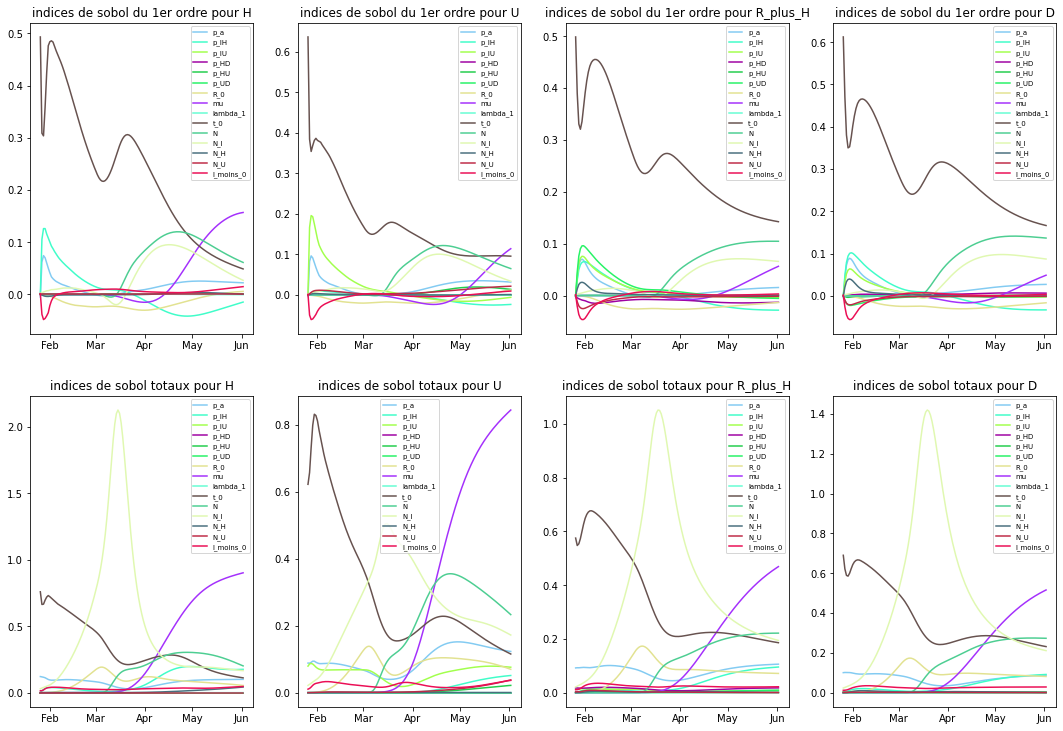

In [99]:
title = ['H','U', 'R_plus_H', 'D']
indices = ['du 1er ordre', 'totaux']
couleurs=[(np.random.rand(),np.random.rand(),np.random.rand()) for i in range(20)]  
for j in range(len(VAR)):
    plt.subplot(2, 4, j+1)
    for i in range(len(VAR[0][0])):
        plt.plot(pd.date_range(start =  '2020-01-25', end = '2020-06-02', freq = 'D'),VAR[j][:,i],label=problem['names'][i], color= couleurs[i])
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=2.5, wspace=None, hspace=None)
    plt.legend(loc='best', fontsize='x-small')
    plt.title('indices de sobol ' + indices[j//4] + ' pour ' + title[j%4])
    
    ### Permet d'avoir un axe des abscisses lisible
    locator = mdates.MonthLocator()
    fmt = mdates.DateFormatter('%b')
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
plt.show()


En analysant les courbes precédentes il vient que seul $t_O$ est influant au depart et que son influence diminue au fur et à mesure, ce qui est cohérent avec la définition de $t_0$.

Conernant les autres paramètres, au départ ils sont nulles et fluctuent au cours de l'éipdémie. Plus particulièrement on remarque que certains paramètres ont leur effet propre en intéraction avec les autres variables qui augmente et atteint un maximum juste avant le pic de l'épidémie (comme $N_I$) et d'autres pendant ou après le pic de l'épidémie (comme $\mu$ ou $N$). 
En ce qui concerne le paramètre $\mu$ sonr importance ne fait que croitre une fois l'épidémie demarré ce qui semble cohérent au vu de sa définition,$\mu$ représente taux de d ́ecroissance de la transmission

# Calibration

In [6]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import ticker

In [7]:

contamination = pd.read_csv('data_per_day.csv', sep = ';')
contamination.columns = [jour,'detecte']
contamination[jour] = pd.to_datetime(contamination[jour],infer_datetime_format = True)
contamination = contamination[contamination[jour]<= '2020-05-11']
contamination['detecte'] = contamination['detecte'].diff(periods = 1)

 
hosp          = pd.read_csv('donnees_hospitalieres.csv', ';')
hosp[jour]    = pd.to_datetime(hosp[jour])
hosp          = hosp.groupby(jour).agg('sum').reset_index(False)[[jour,'hosp','rea','rad','dc']]
big_table     = hosp.merge(contamination, left_on= jour, right_on = jour)
big_table     = big_table[big_table[jour]<= '2020-05-11']
big_table.head()   

,jour,hosp,rea,rad,dc,detecte
0,2020-03-18,5905,1535,1627,435,1404.0
1,2020-03-19,7961,1975,2322,642,1861.0
2,2020-03-20,10272,2564,3128,890,1617.0
3,2020-03-21,11599,2872,3580,1041,1847.0
4,2020-03-22,13675,3311,4188,1251,1559.0


Text(0.5, 1.0, 'Spread of the epidemic')

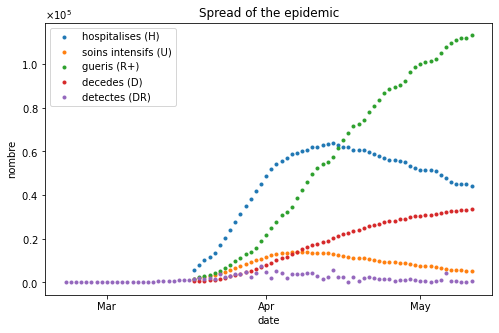

In [8]:
columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

# Calibration déterministe

Pour répondre à cette question, nous lançons la fonction `minimize` de scipy.optimize 100 fois et nous gardons uniquement le 15-uplets de valeurs qui minimise le plus fortement la fonction objectif.

Une telle démarche a nécessairement un coût de calcul assez fort et nous sauvons donc le tout dans un excel fournit avec le jupyter. Afin de pouvoir générer les variables veuillez mettre `generate_variables` à la valeur `True`. Autrement, les variables seront importées depuis le fichier CSV en question. 

In [9]:
from scipy.optimize import minimize
generate_variables = False

In [10]:
# Table pre-processing
contamination = contamination[('2020-02-25' <= contamination[jour])& (contamination[jour]<= '2020-03-31')]
big_table     = big_table[big_table[jour]<= '2020-03-31']
sigmas        = [1,1,1,1,1]

In [11]:

def Epsilon(variables,constants,contamination = contamination,big_table=big_table,global_constants=global_constants, sigmas = sigmas,n_DR=n_DR,n_H=n_H):
    """
    parameters will be a dictionnary similar to the one resulting from init_constant    
    """
    
    syst_CI=array([global_constants['S_0'],variables[-1],0,0,0,0,0,0,0,0])
    simulation=odeint(equa_diff,syst_CI,constants[-3],args = (variables,constants))
           
    DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1])/sigmas[0])**2
    
    H  = ((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5])/sigmas[1])**2
    U  = ((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6])/sigmas[2])**2
    D  = ((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8])/sigmas[3])**2
    R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7])/sigmas[4])**2
    return np.sum(DR) + np.sum(H+U+D+R)



In [12]:


def q_7_function():
    """
    This function compute the minimization routine one time and return the 15-uplet and the value of the objectiv function.    
    """
    variables = init_variables(T_MAX = 66)
    constants = compute_constants(variables, global_constants = global_constants)
    variables = list(variables.values())
    constants = list(constants.values())

    res = minimize(Epsilon,x0 = variables,bounds = bound, args = (constants))
    optimal_variables = dict(zip(variables_keys,res.x))
    return optimal_variables,res.fun

if generate_variables :     
    all_results = []
    all_variables = []
    pbar = ProgressBar()

    for i in pbar(range(100)):
        optimal_variables, res = q_7_function()
        all_results.append(res)
        all_variables.append(optimal_variables)
    
    best_variables = all_variables[np.argmin(all_results)]
    with open('best_variables_q7_odeint.csv', 'w') as f:
        f.write("%s,%s\n"%('variables','values'))
        for key in best_variables.keys():
            f.write("%s,%s\n"%(key,best_variables[key]))
    
    
else : 
    best_variables = pd.read_csv('best_variables_q7_odeint.csv', ',')
    best_variables = best_variables['values'].to_numpy()
    best_variables = dict(zip(variables_keys,best_variables))
    

In [13]:

constants  = compute_constants(best_variables)
syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))[::int(1/global_constants['deltaT'])]


Text(0.5, 1.0, 'Spread of the epidemic')

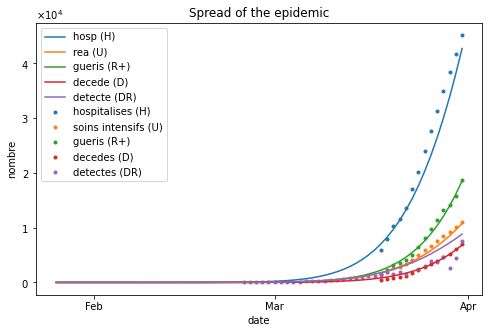

In [14]:
fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
columns  = [5,6,7,8,9]
titles   = {'5':'hosp (H)','6': 'rea (U)','8':'decede (D)', '9':'detecte (DR)','7': 'gueris (R+)'}
time     = pd.date_range(start =  '2020-01-26', end = '2020-03-31', freq = 'D')

for i,col in enumerate(columns) : 
    axs.plot(time,simulation[:66,col], label = titles[f"{col}"])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')



columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

8) **Donnez les valeurs de $\sigma_C$ pour $C$ dans $\{H,U,D,R\}$**

L'énoncé nous dit que : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{DR}^{-n_{DR}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$

Que l'on peut réécrire de la manière suivante afin de d'utiliser une optimisation sous log-vraisemblance par la suite : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$


On atteint un optimum pour l'expression suivante quand toutes les compostantes du gradient sont nulles. En raisonnant pour $\sigma_{DR}$ on a : 

$\begin{align}
\frac{\partial}{\sigma_{DR}}p(data|x,\sigma)&=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times(-\frac{n_{DR}}{\sigma_{DR}}+\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}})e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}\\
&=0
\end{align}$
Ce qui revient à écrire que : 


$\begin{align}
& \ \frac{n_{DR}}{\sigma_{DR}}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}}\\
\Leftrightarrow &  \ \sigma_{DR}^{2}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{n_{DR}}
\end{align}$

En raisonnant de même pour les autres sigmas, il vient que :

$\sigma_{C}^{2}=\sum_{i=1}^{n_{H}}\frac{f_{C}(x,s_{i})^{2}}{n_{H}}$



9) **Donner une expression implicite de la loi a posteriori $p(x|data)$ des paramètres x.**

Le théorème de Bayes nous donne que : $p(x|data) \propto p(data|x)p_0(x)$.

Pour l'approche plug-in, on fixe les valeurs de sigma tel que définis à la question 8. Dans ce cas, on a : 

$\begin{equation}
p(x|data)=p(data|x)p_0(x)
\end{equation}$

Dans le cadre de l'approche full-bayésienne comme on a : $\pi(\sigma_C)=(\sigma_C)^{-1}$ pour $C$ dans $\{H,U,D,R\}$ alors on peut écrire que : $\begin{align}
p(x|data) &\propto \int_{\sigma}p(x,\sigma|data)d\sigma\\
&\propto \int_{\sigma}p(data|x,\sigma)p(\sigma)p_0(x)d\sigma
\end{align}$

En utilisant les expressions de chacun des $\sigma$ on peut développer l'intégrale et donner une expression implicite de cette densité. 


10) **Dans le cas plug-in, puis dans le cas full-bayésien, comparer les lois a priori et a posteriori uni-dimensionnelles de chacun des paramètres (histogramme,moyenne, variance). Estimer la matrice de corrélation a posteriori des paramètres. Quels sont les paramètres pour lesquels l'incertitude a été fortement réduite ou au contraire très peu réduite ?**


Nous connaissons les lois à postériori à une constante multiplicative près. De ce fait nous souhaitons donc simuler la distribution de $p(x|data)$ en utilisant un algorithme de Metropolis Hasting. 

A partir d'un point $X_0$, nous construisons la chaîne de Markov de la façon suivante : 

- On propose un déplacement vers $\tilde{X}_{n+1}$ selon la loi $q(X_n,\sigma^2I)$ supposée gaussienne. On améliorera la matrice de covariance de cette loi durant la procédure de burn-in. 

- On accepte le déplacement avec la probabilité $a(X_n,\tilde{X}_{n+1})$. La fonction $a$ est définie comme suit : 

\begin{align}
a(X_n,\tilde{X}_{n+1}) &= min\{\frac{p(\tilde{X}_{n+1}|data)Q(X_n,\tilde{X}_{n+1})}{p(X_n|data)Q(\tilde{X}_{n+1},X_n)},1\}\\
&= min\{\frac{p(data|\tilde{X}_{n+1})Q(X_n,\tilde{X}_{n+1})}{p(data|X_n)Q(\tilde{X}_{n+1},X_n)},1\}
\end{align}

La difficulté que nous rencontrons ici est que les paramètres doivent évoluer dans un certain intervalle. Par exemple, la proportion de personne passant d'un compartiment à l'autre (ex : $p_a$) est dans $[0,1]$. Tous les paramètres doivent être positifs. Afin de pouvoir jouer avec ces disparités, nous avons tout d'abord essayé de tirer ces paramètres selon des lois lognormales ou bêta. Néanmoins nous ne maîtrisions pas bien ces lois. Nous proposons ci-dessous un pseudo-algorithme décrivant notre procédure. 

1. Approche plug-in 

Le dictionnaire `F` contient les lois que l'on va utiliser pour calculer les paramètres. Dans cette approche nous prenons uniquement des lois normales. Le dictionnaire `F_parameters` contient les paramètres initiaux de ces lois. Il est mis à jour tout au long de la phase de burning. 

- Tirage de $X\_$ selon l'ensemble des lois de `F` (fonction `move`) et la position actuelle de la chaîne $X$
- On vérifie si le déplacement est acceptable (fonction `not_accepted_move`) : les paramètres sont-ils dans le bon intervalle. Si $X\_$ n'est pas accepté on choisit $X$ comme nouvelle position de la chaîne. 
- On calcule $a$ selon la formule de MH. 
- Pendant la phase de burnin on regroupe dans la variable `accepted_history` le nombre de déplacements acceptés depuis le dernier ajustement des paramètres.





In [15]:
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import uniform
import seaborn as sn

np.random.seed(4)

In [47]:



F = {'p_a': 'norm',
    'p_IH': 'norm',
    'p_IU': 'norm',
    'p_HD': 'norm',
    'p_HU': 'norm',
    'p_UD': 'norm',
    'N_I' : 'norm',
    'N_H' : 'norm',
    'N_U' : 'norm',
    'R_0' : 'norm',
    'mu'  : 'norm',
    'N'   : 'norm',
    't_0'   : 'norm',
    'I_moins_0' : 'norm',
    'lambda_1' : 'norm'
}



F_parameters_plug_in = {'p_a': {'loc':0.65,'scale':0.014343349452669072},
    'p_IH': {'loc':0.125,'scale':0.014343349452669072},
    'p_IU': {'loc':0.025,'scale':0.014343349452669072},
    'p_HD': {'loc':0.15,'scale':0.014343349452669072},
    'p_HU': {'loc':0.15,'scale':0.014343349452669072},
    'p_UD': {'loc':0.3,'scale':0.014343349452669072},
    'N_I' : {'loc':10,'scale':0.14343349452669066},
    'N_H' : {'loc':20,'scale':0.14343349452669066},
    'N_U' : {'loc':15,'scale':0.14343349452669066},
    'R_0' : {'loc':3.15,'scale':0.1*0.14343349452669066},
    'mu'  : {'loc':0.05,'scale':0.01*0.14343349452669066},
    'N'   : {'loc':40,'scale':0.14343349452669066},
    't_0' : {'loc':15, 'scale':0.14343349452669066},
    'I_moins_0' : {'loc':50,'scale':0.14343349452669066},
    'lambda_1' : {'loc':0.5*10**(-4),'scale':10**(-5)}
}



In [48]:
def not_accepted_move_v2(X_):
    
    variables = dict(zip(variables_keys,X_))
    for key,value in variables.items():
        if not bounds[key]['low']<=value<= bounds[key]['high']:
            #print('here',key,value)
            return True
    return False

def not_accepted_move(X_):
    
    variables = dict(zip(variables_keys,X_))
    for key,value in variables.items():
        if key in ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD'] and not 0<=value<=1 :
            return True 
        if key in ['N_I','N_H','N_U','R_0','mu','N','t_0','I_moins_0','lambda_1'] and value < 0 :
            return True
        if key == 'I_moins_0' and value < 1 : 
            return True    
    if variables['t_0'] >= variables['N'] :        
        return True
    
    return False
        
    

def move(X,F_current_parameters):
    """
    Generate a possible movement for our scale
    """
    variables = dict(zip(variables_keys,X))
    X_ = []
    for key,values in variables.items() :
        f = F[key]
        if f == 'lognorm':
            x_ = lognorm.rvs(s = F_current_parameters[key]['s'], scale = values)
        if f == 'norm'   : 
            x_ = norm.rvs(loc = values, scale = F_current_parameters[key]['scale'] )
        if f == 'uniform' : 
            
            if F_parameters[key]['constraint']=='one':
                if values-F_current_parameters[key]['scale']/2 < F_parameters[key]['low'] :
                    F_current_parameters[key]['scale'] = 2*(values-F_parameters[key]['low'])
                    
            if F_parameters[key]['constraint']=='two':
                if values-F_current_parameters[key]['scale']/2 < F_parameters[key]['low'] or values+F_current_parameters[key]['scale']/2 > F_parameters[key]['high']:
                    F_current_parameters[key]['scale'] = min(2*(values-F_parameters[key]['low']),2*(F_parameters[key]['high']-values))
                    print('two',min(2*(values-F_parameters[key]['low']),2*(F_parameters[key]['high']-values)))
            x_ = uniform.rvs(loc = values - F_current_parameters[key]['scale']/2, scale = F_current_parameters[key]['scale'])
            
        if f == 'beta' :
            x_ = beta.rvs(loc = F_current_parameters[key]['loc'], scale = F_current_parameters[key]['scale'], a = 5, b = 5)
        X_.append(x_)
    return X_


def Q(X,X_,F_current_parameters):
    """
    Give the propability of the transition
    """
    probs = []
    
    variables  = dict(zip(variables_keys,X))
    variables_ = dict(zip(variables_keys,X_))  
    for key in variables_keys : 
        f = F[key]
        if f == 'lognorm':
            prob = lognorm.pdf(variables[key], s = variables_[key], scale = F_current_parameters[key]['scale'])
        if f == 'norm'   : 
            prob = norm.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'])
        if f == 'uniform':
            prob = uniform.pdf(variables[key], loc = variables_[key] - F_current_parameters[key]['scale']/2 ,scale = F_current_parameters[key]['scale'] )
        if f == 'beta' : 
            prob = beta.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'], a = 5 , b = 5)
        
        probs.append(prob)

        
    probs = np.array(probs)
    
    return np.prod(probs)

def a_plug_in(X,X_,sigmas,F_current_parameters):
    """
    Given a former position X and a new position X_, return the new position
    """
    if not_accepted_move_v2(X_):
        return 0
    ratio = plug_in(X,X_,sigmas)*Q(X,X_,F_current_parameters)/Q(X_,X,F_current_parameters)
    minimum = min(ratio,1)
   
    U     = np.random.uniform()
    if U> minimum : 
        return 0
    else :
        return 1
    
def Metropolis_Hasting_plug_in(X,F_parameters,n= 5000,do_burn = False):
    """
    Given a random point X, we return a sample of Metroplis Hasting of size n. 
    """
    
    X = (list(X.values()))
    chain = [X]
    
    burn_in = int(n*0.4)
    burn_in_period = 20   
    thining_period = 4
    
    acceptation_history = np.zeros(burn_in_period)
    sigmas = compute_sigmas()
    print(sigmas)
    pbar   = ProgressBar()
    for i in pbar(range(n)):
        X  = chain[-1]
        X_ = move(X,F_parameters)
        test = a_plug_in(X,X_,sigmas,F_parameters)
        
        if 1 < i < burn_in : 
        
            if test == 1 :             
                chain.append(X_)
            acceptation_history[i%burn_in_period] = test        
            
            if i % burn_in_period == 0 and do_burn :
                rate = np.mean(acceptation_history)
                if rate < 0.25 : 
                    update_F('down')
                    #print('down',rate)
                if rate > 0.50 : 
                    update_F('up')
                    #print('up',rate)
                acceptation_history = np.zeros(burn_in_period)
        if i == burn_in : 
            
            print('start thining')
            chain = [chain[-1]]
        
        if i >= burn_in:     
            if i % thining_period == 0:
                if test == 1 : 
                    chain.append(X_)          
    
    return chain

def update_F(variation,F = F, F_parameters = F_parameters_plug_in):
    
    for key in F_parameters.keys() : 
        if F[key] == 'norm':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        
            
def plug_in(X,X_,sigmas):
    
    """
    Given the set of best variables, return the plug in probability according to the data.
    """
    variables  = dict(zip(variables_keys,X))
    variables_ = dict(zip(variables_keys,X_))
    constants  = compute_constants(variables)
    constants_  = compute_constants(variables_)
   
    constants  = list(constants.values())
    constants_ = list(constants_.values())
    result     = (Epsilon(X_,constants,sigmas = sigmas))/(Epsilon(X,constants,sigmas = sigmas))
  
        
    return np.exp(result)

def compute_sigmas(best_variables = best_variables,n_DR=n_DR,n_H=n_H,contamination = contamination,big_table=big_table):
    
    constants  = compute_constants(best_variables)
    syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
    simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))
    
    
    sigma_DR = np.sqrt(np.mean(((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2))
    
    sigma_H  = np.sqrt(np.mean(((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2))
    sigma_U  = np.sqrt(np.mean(((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2))
    sigma_D  = np.sqrt(np.mean(((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2))
    sigma_R  = np.sqrt(np.mean(((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2))
    
    sigmas = [sigma_DR,sigma_H,sigma_U,sigma_D,sigma_R]
    return sigmas

variables = init_variables(T_MAX = 66)

chain_plug_in = Metropolis_Hasting_plug_in(variables, F_parameters_plug_in)

[16.38983036608388, 19.281909366858837, 6.88155979859995, 7.016065730543779, 6.842863497953386]


start thining


100% |########################################################################|


15

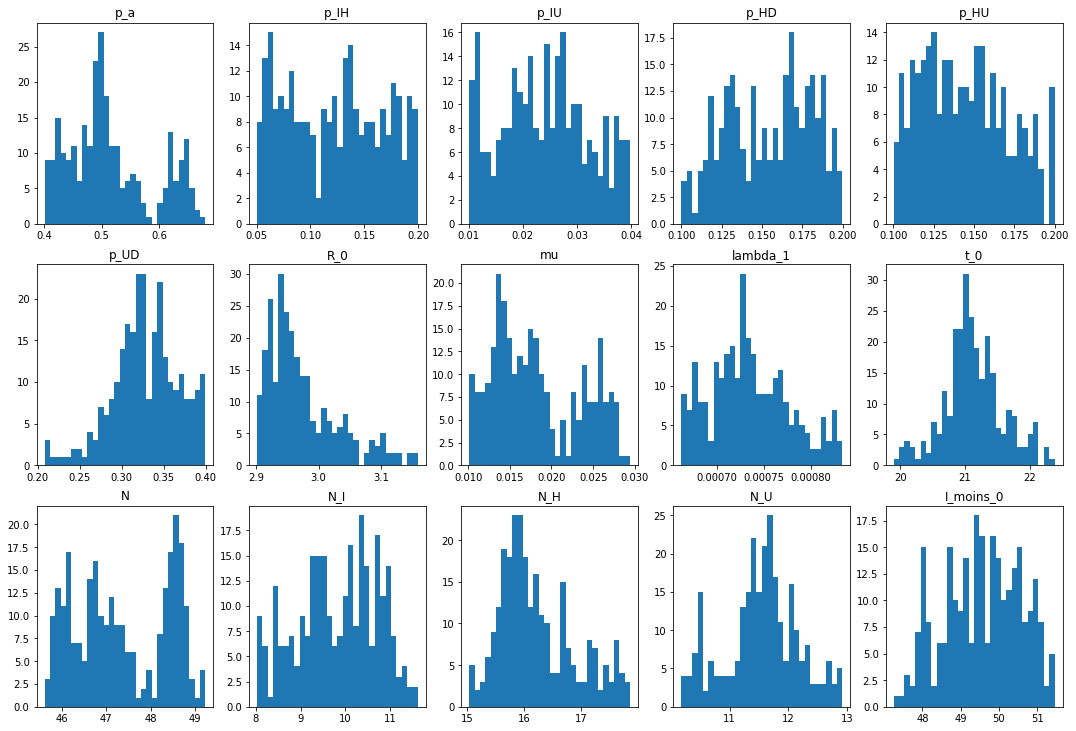

In [56]:
plt.hist(np.array(chain_plug_in)[:,0], bins= 30)
title = ['H','U', 'R_plus_H', 'D']
indices = ['du 1er ordre', 'totaux']
for j in range(len(chain_plug_in[0])):
    plt.subplot(3, 5, j+1)
    plt.hist(np.array(chain_plug_in)[:,j], bins= 30)
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=2.5, wspace=None, hspace=None)
    plt.title(variables_keys[j])
plt.show()

La matrice de correlation est : 

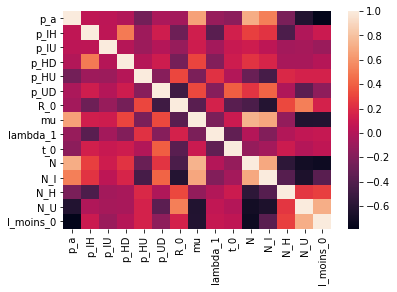

In [57]:
df_plug_in = pd.DataFrame(chain_plug_in,columns = variables_keys)
corrMatrix = df_plug_in.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

2. Cas full Bayésien

In [74]:
F_fb_parameters = {'p_a': {'loc':0.65,'scale':0.1},
    'p_IH': {'loc':0.125,'scale':0.1},
    'p_IU': {'loc':0.025,'scale':0.1},
    'p_HD': {'loc':0.15,'scale':0.1},
    'p_HU': {'loc':0.15,'scale':0.1},
    'p_UD': {'loc':0.3,'scale':0.1},
    'N_I' : {'loc':10,'scale':1},
    'N_H' : {'loc':20,'scale':1},
    'N_U' : {'loc':15,'scale':1},
    'R_0' : {'loc':3.15,'scale':1},
    'mu'  : {'loc':0.05,'scale':0.1},
    'N'   : {'loc':40,'scale':1},
    't_0' : {'loc':15, 'scale':1},
    'I_moins_0' : {'loc':50,'scale':1},
    'lambda_1' : {'loc':0.5*10**(-4),'scale':10**(-5)},
    'sigma_DR':{'loc':15,'scale':1},
    'sigma_H':{'loc':15,'scale':1},
    'sigma_U':{'loc':15,'scale':1},
    'sigma_D':{'loc':15,'scale':1},
    'sigma_R':{'loc':15,'scale':1}
}

F_fb = {'p_a': 'norm',
    'p_IH': 'norm',
    'p_IU': 'norm',
    'p_HD': 'norm',
    'p_HU': 'norm',
    'p_UD': 'norm',
    'N_I' : 'norm',
    'N_H' : 'norm',
    'N_U' : 'norm',
    'R_0' : 'norm',
    'mu'  : 'norm',
    'N'   : 'norm',
    't_0'   : 'norm',
    'I_moins_0' : 'norm',
    'lambda_1' : 'norm',
    'sigma_DR':'norm',
    'sigma_H':'norm',
    'sigma_U':'norm',
    'sigma_D':'norm',
    'sigma_R':'norm'
}



bounds = {'p_a': {'low':0.4,'high':0.9},
    'p_IH': {'low':0.05,'high':0.2},
    'p_IU': {'low':0.01,'high':0.04},
    'p_HD': {'low':0.1,'high':0.2},
    'p_HU': {'low':0.1,'high':0.2},
    'p_UD': {'low':0.2,'high':0.4},
    'N_I' : {'low':8,'high':12},
    'N_H' : {'low':15,'high':25},
    'N_U' : {'low':10,'high':20},
    'R_0' : {'low':2.9,'high':3.4},
    'mu'  : {'low':0.01,'high':0.08},
    'N'   : {'low':30,'high':50},
    't_0' : {'low':1, 'high':30},
    'I_moins_0' : {'low':1,'high':100},
    'lambda_1' : {'low':10**(-4),'high':10**(-3)},
    'sigma_DR':{'low':0,'high':30},'sigma_H':{'low':5,'high':30},'sigma_U':{'low':5,'high':30},'sigma_D':{'low':5,'high':30},'sigma_R':{'low':5,'high':30}
}

In [75]:
def not_accepted_move_v2(X_):
    
    variables = dict(zip(variables_fb_keys,X_))
    for key,value in variables.items():
        if not bounds[key]['low']<value<= bounds[key]['high']:
            #print('here',key,value)
            return True
    return False


        
    

def move_fb(X,F_current_parameters):
    """
    Generate a possible movement for our scale
    """
    variables = dict(zip(variables_fb_keys,X))
    X_ = []
    for key,values in variables.items() :
        f = F_fb[key]
        if f == 'norm'   : 
            x_ = norm.rvs(loc = values, scale = F_current_parameters[key]['scale'] )
        X_.append(x_)
    return X_


def Q(X,X_,F_current_parameters):
    """
    Give the propability of the transition
    """
    probs = []
    
    variables  = dict(zip(variables_fb_keys,X))
    variables_ = dict(zip(variables_fb_keys,X_))  
    for key in variables_keys : 
        f = F[key]        
        if f == 'norm'   : 
            prob = norm.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'])        
        probs.append(prob)

        
    probs = np.array(probs)
    
    return np.prod(probs)

def a_fb(X,X_,F_current_parameters):
    """
    Given a former position X and a new position X_, return the new position
    """
    if not_accepted_move_v2(X_):
        return 0
    
    ratio = fb(X,X_)*Q(X,X_,F_current_parameters)/Q(X_,X,F_current_parameters)
    minimum = min(ratio,1)
   
    U     = np.random.uniform()
    if U> minimum : 
        return 0
    else :
        return 1
    
def Metropolis_Hasting_full_bayésien(X,F_fb_parameters,n= 5000,do_burn = True):
    """
    Given a random point X, we return a sample of Metroplis Hasting of size n. 
    """
    
    X = (list(X.values()))
    chain = [X]
    
    burn_in = int(n*0.4)
    burn_in_period = 20   
    thining_period = 4
    
    acceptation_history = np.zeros(burn_in_period)
    pbar   = ProgressBar()
    for i in pbar(range(n)):
        X  = chain[-1]
        X_ = move_fb(X,F_fb_parameters)
        test = a_fb(X,X_,F_fb_parameters)
        
        if 1 < i < burn_in : 
        
            if test == 1 :             
                chain.append(X_)
            acceptation_history[i%burn_in_period] = test        
            
            if i % burn_in_period == 0 and do_burn :
                rate = np.mean(acceptation_history)
                #print(rate)
                if rate < 0.25 : 
                    update_F('down')
                    #print('down',rate)
                if rate > 0.50 : 
                    update_F('up')
                    #print('up',rate)
                acceptation_history = np.zeros(burn_in_period)
        if i == burn_in : 
            
            print('start thining')
            chain = [chain[-1]]
        
        if i >= burn_in:     
            if i % thining_period == 0:
                if test == 1 : 
                    chain.append(X_)          
    
    return chain

def update_F(variation,F = F_fb, F_parameters = F_fb_parameters):
    
    for key in F_parameters.keys() : 
        if F_fb[key] == 'norm':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        
            
def fb(X,X_):
    
    """
    Given the set of best variables, return the plug in probability according to the data.
    """
    variables  = dict(zip(variables_fb_keys,X))
    variables_ = dict(zip(variables_fb_keys,X_))
    constants  = compute_constants(variables)
    constants_  = compute_constants(variables_)
    constants  = list(constants.values())
    constants_ = list(constants_.values())
    result     = (X[15]/X_[15])**n_DR*(np.prod(X[16:])/np.prod(X_[16:]))**n_H
    result     *=np.exp((Epsilon(X_[:15],constants,sigmas = X_[15:]))/(Epsilon(X[:15],constants,sigmas = X[15:])))
    return result



variables = init_variables(T_MAX = 66)
for sigma in ['sigma_DR','sigma_H','sigma_U','sigma_D','sigma_R']:
    variables[sigma] = 10

chain_fb = Metropolis_Hasting_full_bayésien(variables, F_fb_parameters)

<ipython-input-75-78f936a086d7>:132: RuntimeWarning: overflow encountered in exp
  result     *=np.exp((Epsilon(X_[:15],constants,sigmas = X_[15:]))/(Epsilon(X[:15],constants,sigmas = X[15:])))


start thining


100% |########################################################################|


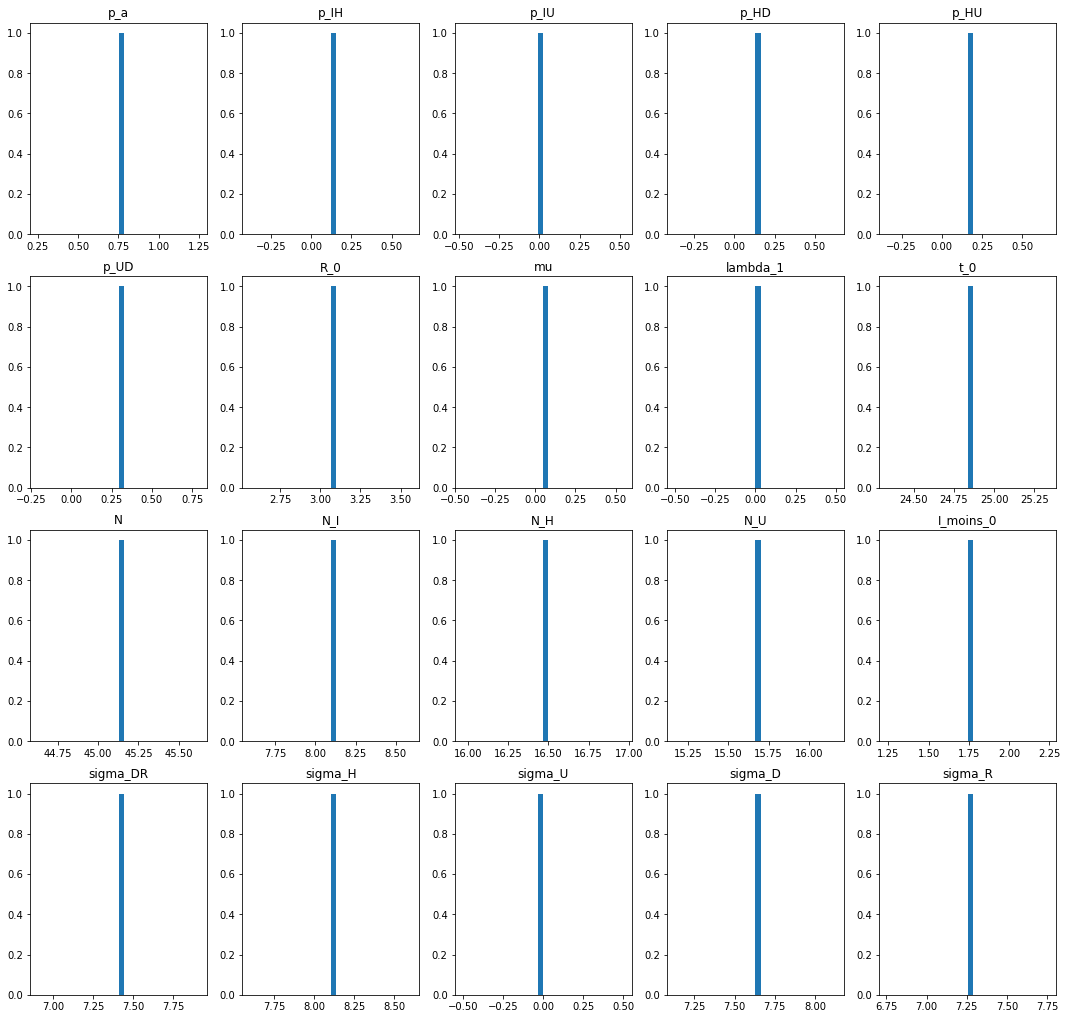

In [76]:
plt.hist(np.array(chain_fb)[:,0], bins= 30)
title = ['H','U', 'R_plus_H', 'D']
indices = ['du 1er ordre', 'totaux']
for j in range(len(chain_fb[0])):
    plt.subplot(4, 5, j+1)
    plt.hist(np.array(chain_fb)[:,j], bins= 30)
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3.5, wspace=None, hspace=None)
    plt.title(variables_fb_keys[j])
plt.show()

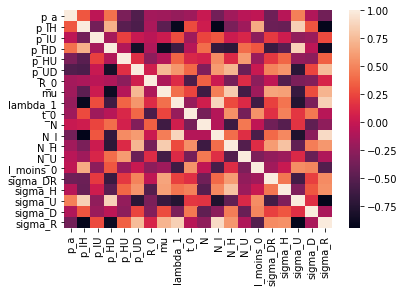

In [70]:
df_fb = pd.DataFrame(chain_fb,columns = variables_fb_keys)
corrMatrix = df_fb.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

11) **Donner les prédictions du 1er avril au 11 mai 2020 des nombres des individus hospitalisés, en soins intensifs et morts avec leurs intervalles de confiance, sachant les données jusqu'au 31 mars. On pourra recommencer en prenant comme données celles jusqu'au 14 avril.**


Nous avons pu extraire de chacune des méthodes les échantillons des lois stationnaires qu'on a stocké dans des DataFrame : `df_plug_in` et `df_fb`. Nous allons donc extraire les paramètres optimaux de ces jeux de données pour ensuite effectuer la simulation jusqu'aux dates demandées.